In [1]:
import torch
import torchvision
from torchvision import transforms
import numpy as np

In [2]:
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import torch.nn as nn


### **Loading the CelebA dataset**

In [3]:
import torchvision 

image_path = './'
celeba_train_dataset = torchvision.datasets.CelebA(image_path, split='train', target_type='attr', download=False)
celeba_valid_dataset = torchvision.datasets.CelebA(image_path, split='valid', target_type='attr', download=False)
celeba_test_dataset = torchvision.datasets.CelebA(image_path, split='test', target_type='attr', download=False)

print('Train set:', len(celeba_train_dataset))
print('Validation set:', len(celeba_valid_dataset))
print('Test set:', len(celeba_test_dataset))

Train set: 162770
Validation set: 19867
Test set: 19962


### **Image transformation and data augmentation**

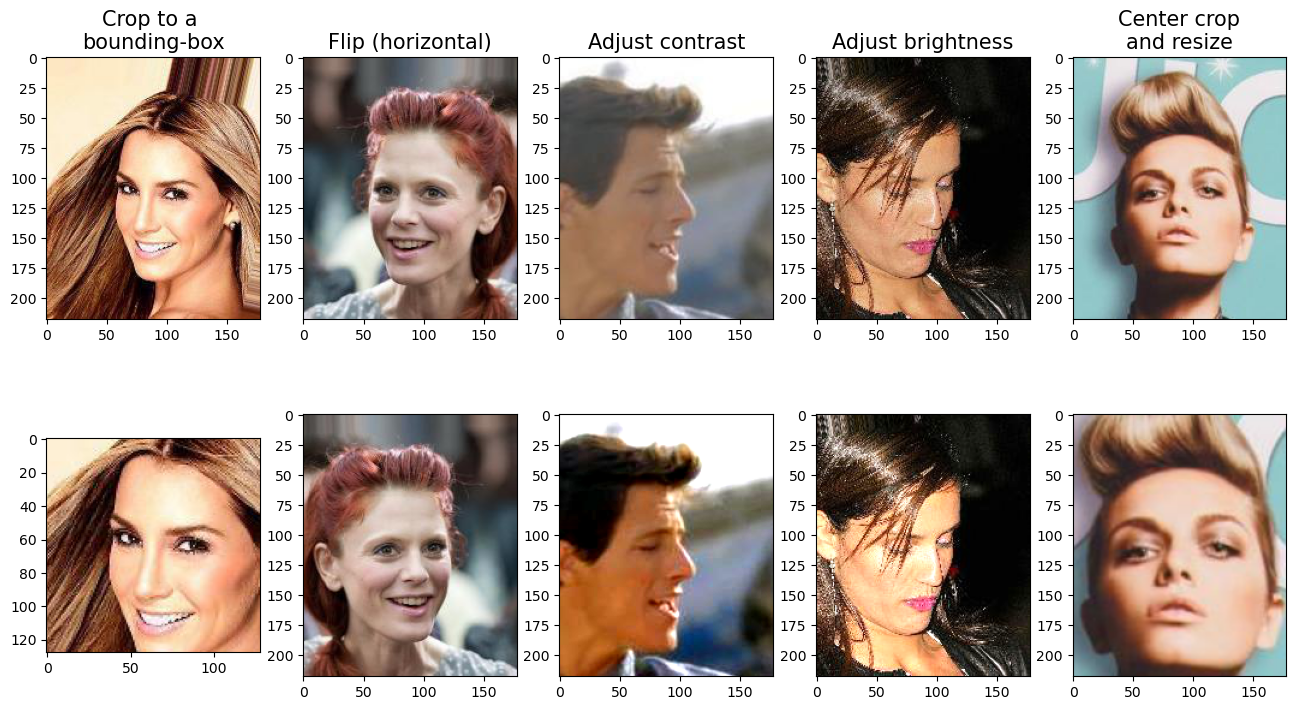

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16,8.5))
## column 1: cropping to a bounding-box
ax = fig.add_subplot(2,5,1)
img,attr = celeba_train_dataset[0]
ax.set_title('Crop to a \nbounding-box',size=15)
ax.imshow(img)
ax = fig.add_subplot(2,5,6)
img_cropped = transforms.functional.crop(img,50,20,128,128)
ax.imshow(img_cropped)

## Column 2: flipping (horizontally)
ax = fig.add_subplot(2,5,2)
img,attr = celeba_train_dataset[1]
ax.set_title('Flip (horizontal)',size=15)
ax.imshow(img)
ax = fig.add_subplot(2,5,7)
img_flipped = transforms.functional.hflip(img)
ax.imshow(img_flipped)

## Column 3: adjust contrast
ax = fig.add_subplot(2,5,3)
img,attr = celeba_train_dataset[2]
ax.set_title('Adjust contrast',size=15)
ax.imshow(img)
ax = fig.add_subplot(2,5,8)
img_adj_contrast = transforms.functional.adjust_contrast(img,contrast_factor=2)
ax.imshow(img_adj_contrast)

## Column 4: adjust brightness
ax = fig.add_subplot(2,5,4)
img,attr = celeba_train_dataset[3]
ax.set_title('Adjust brightness',size=15)
ax.imshow(img)
ax = fig.add_subplot(2,5,9)
img_adj_brightness = transforms.functional.adjust_brightness(img,brightness_factor=1.3)
ax.imshow(img_adj_brightness)

## Column 5: cropping from image center
ax = fig.add_subplot(2,5,5)
img,attr = celeba_train_dataset[4]
ax.set_title('Center crop\nand resize',size=15)
ax.imshow(img)
ax = fig.add_subplot(2,5,10)
img_center_crop = transforms.functional.center_crop(img,[0.7*218,0.7*178])
img_resized = transforms.functional.resize(img_center_crop,size=(218,178))
ax.imshow(img_resized)
plt.show()

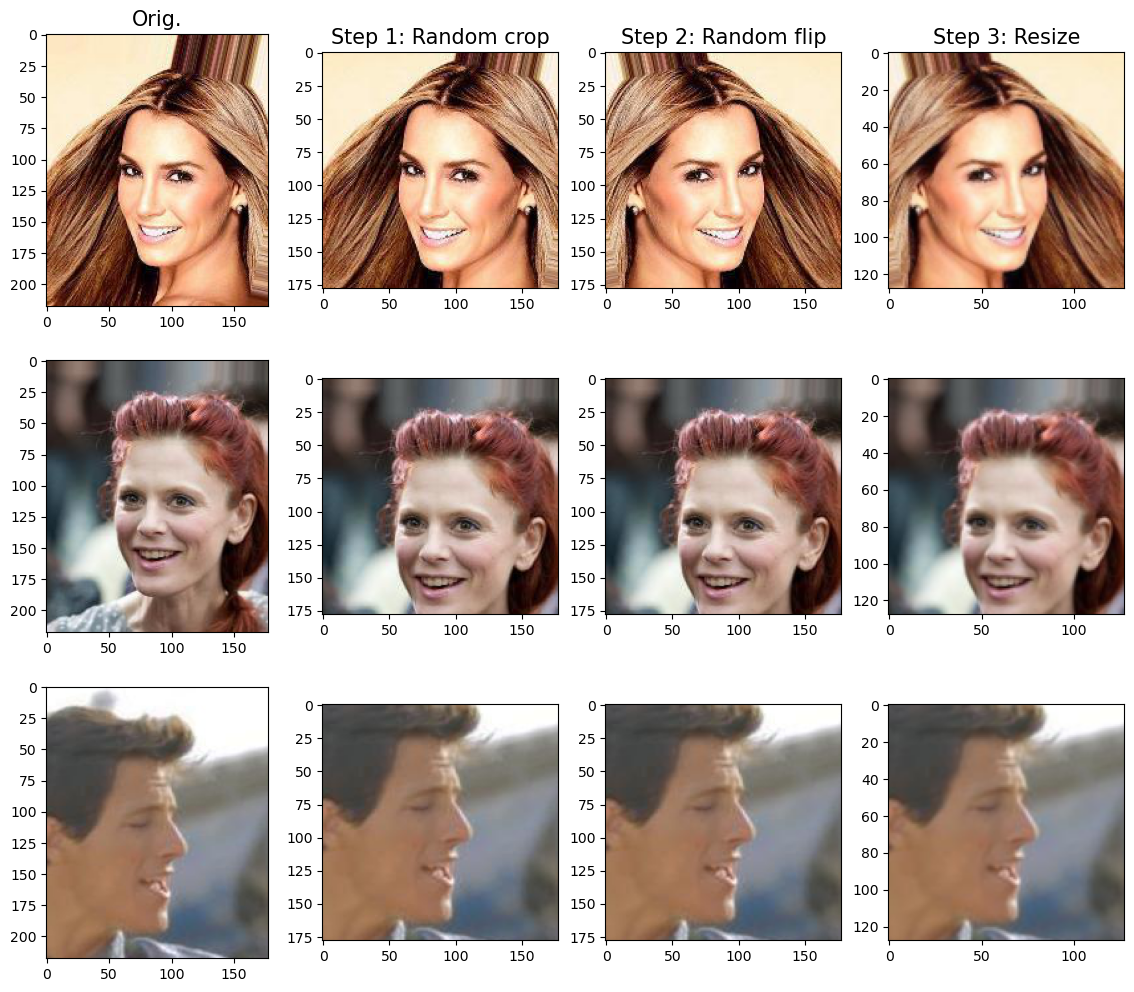

In [5]:
torch.manual_seed(1)
fig = plt.figure(figsize=(14,12))
for i, (img,attr) in enumerate(celeba_train_dataset):
    ax = fig.add_subplot(3,4,i*4+1)
    ax.imshow(img)
    if i==0:
        ax.set_title('Orig.',size=15)
    ax = fig.add_subplot(3,4,i*4+2)
    img_transform = transforms.Compose([
        transforms.RandomCrop([178,178])
    ])
    img_cropped = img_transform(img)
    ax.imshow(img_cropped)
    if i ==0:
        ax.set_title('Step 1: Random crop',size=15)
    
    ax = fig.add_subplot(3,4,i*4+3)
    img_transform = transforms.Compose([
        transforms.RandomHorizontalFlip()
    ])
    img_flip = img_transform(img_cropped)
    ax.imshow(img_flip)
    if i ==0:
        ax.set_title('Step 2: Random flip',size=15)
    ax = fig.add_subplot(3,4,i*4+4)
    img_resized = transforms.functional.resize(img_flip,size=(128,128))
    ax.imshow(img_resized)
    if i==0:
        ax.set_title('Step 3: Resize',size=15)
    if i==2:
        break
plt.show()

In [6]:
get_smile = lambda attr: attr[18]

In [7]:
transform_train = transforms.Compose([
    transforms.RandomCrop([178,178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64,64]),
    transforms.ToTensor(),
])

In [8]:
transform = transforms.Compose([
    transforms.CenterCrop([178,178]),
    transforms.Resize([64,64]),
    transforms.ToTensor(),
])

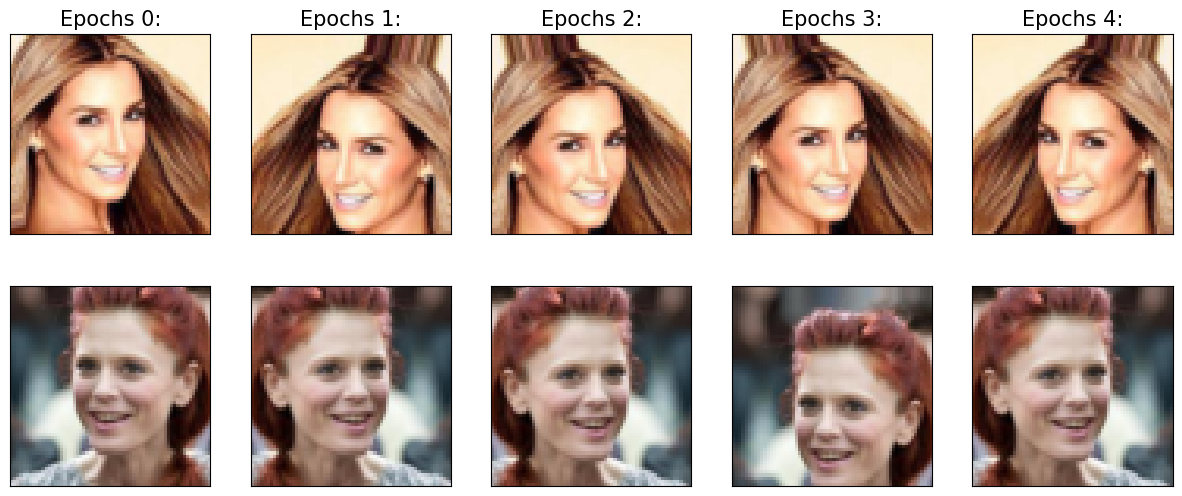

In [9]:
from torch.utils.data import DataLoader

celeba_train_dataset = torchvision.datasets.CelebA(image_path,
                                                  split='train',
                                                  target_type='attr',download=False,
                                                  transform=transform_train,
                                                  target_transform=get_smile)

torch.manual_seed(1)
data_loader = DataLoader(celeba_train_dataset,batch_size=2)
fig = plt.figure(figsize=(15,6))
num_epochs = 5
for j in range(num_epochs):
    img_batch,label_batch = next(iter(data_loader))
    img = img_batch[0]
    ax = fig.add_subplot(2,5,j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epochs {j}:',size=15)
    ax.imshow(img.permute(1,2,0))
    
    img = img_batch[1]
    ax = fig.add_subplot(2,5,j+6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1,2,0))

plt.show()

In [10]:
celeba_valid_dataset = torchvision.datasets.CelebA(image_path,split='valid',
                                                  target_type='attr',download=False,
                                                  transform=transform,target_transform=get_smile)
celeba_test_dataset = torchvision.datasets.CelebA(image_path,split='test',
                                                 target_type='attr',download=False,
                                                 transform=transform,target_transform=get_smile)


Only taking around 16000 of training data and 1000 of validation

In [11]:
from torch.utils.data import Subset
celeba_train_dataset = Subset(celeba_train_dataset,
                             torch.arange(16000))
celeba_valid_dataset = Subset(celeba_valid_dataset,
                             torch.arange(1000))
print('Train set:',len(celeba_train_dataset))
print('Validation set:',len(celeba_valid_dataset))

Train set: 16000
Validation set: 1000


In [12]:
batch_size = 32
torch.manual_seed(1)
train_dl = DataLoader(celeba_train_dataset,batch_size,shuffle=True)
valid_dl = DataLoader(celeba_valid_dataset,batch_size,shuffle=False)
test_dl = DataLoader(celeba_test_dataset,batch_size,shuffle=False)

### **Training a CNN smile classifier**

In [13]:
model = nn.Sequential()
model.add_module('conv1',
                nn.Conv2d(
                in_channels=3,out_channels=32,kernel_size=3,padding=1))
model.add_module('relu1',nn.ReLU())
model.add_module('pool1',nn.MaxPool2d(kernel_size=2))
model.add_module('dropout1',nn.Dropout(p=0.5))

model.add_module('conv2',
                nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1))
model.add_module('relu2',nn.ReLU())
model.add_module('pool2',nn.MaxPool2d(kernel_size=2))
model.add_module('dropout2',nn.Dropout(p=0.5))

model.add_module('conv3',
                nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1))
model.add_module('relu3',nn.ReLU())
model.add_module('pool3',nn.MaxPool2d(kernel_size=2))
model.add_module('dropout3',nn.Dropout(p=0.5))

model.add_module('conv4',
                nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1))
model.add_module('relu4',nn.ReLU())


In [14]:
x  = torch.ones((4,3,64,64))
model(x).shape

torch.Size([4, 256, 8, 8])

In [15]:
model.add_module('pool4',nn.AvgPool2d(kernel_size=8))
model.add_module('flatten',nn.Flatten())
x = torch.ones((4,3,64,64))
model(x).shape

torch.Size([4, 256])

In [16]:
model.add_module('fc',nn.Linear(256,1))
model.add_module('sigmoid',nn.Sigmoid())
x = torch.ones((4,3,64,64))
model(x).shape

torch.Size([4, 1])

In [17]:
model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.5, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [18]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)


In [19]:
def train(model,num_epochs,traind_dl,valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        model.train()
        for x_batch,y_batch in train_dl:
            pred = model(x_batch)[:,0]
            loss = loss_fn(pred,y_batch.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item() *y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch,y_batch in valid_dl:
                pred = model(x_batch)[:,0]
                loss = loss_fn(pred,y_batch.float())
                loss_hist_train[epoch] += loss.item() * y_batch.size(0)
                is_correct = ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: '
             f'{accuracy_hist_train[epoch]:.4f} val_accuracy:'
             f'{accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train,loss_hist_valid,accuracy_hist_train,accuracy_hist_valid
            

In [20]:
torch.manual_seed(1)
num_epochs = 30
hist = train(model,num_epochs,train_dl,valid_dl)

Epoch 1 accuracy: 0.6231 val_accuracy:0.7110
Epoch 2 accuracy: 0.6976 val_accuracy:0.7480
Epoch 3 accuracy: 0.7245 val_accuracy:0.7660
Epoch 4 accuracy: 0.7372 val_accuracy:0.7760
Epoch 5 accuracy: 0.7461 val_accuracy:0.7960
Epoch 6 accuracy: 0.7597 val_accuracy:0.7930
Epoch 7 accuracy: 0.7688 val_accuracy:0.7980
Epoch 8 accuracy: 0.7876 val_accuracy:0.7990
Epoch 9 accuracy: 0.7976 val_accuracy:0.8290
Epoch 10 accuracy: 0.8067 val_accuracy:0.8250
Epoch 11 accuracy: 0.8164 val_accuracy:0.8500
Epoch 12 accuracy: 0.8217 val_accuracy:0.8510
Epoch 13 accuracy: 0.8298 val_accuracy:0.8580
Epoch 14 accuracy: 0.8299 val_accuracy:0.8500
Epoch 15 accuracy: 0.8341 val_accuracy:0.8640
Epoch 16 accuracy: 0.8386 val_accuracy:0.8550
Epoch 17 accuracy: 0.8421 val_accuracy:0.8650
Epoch 18 accuracy: 0.8505 val_accuracy:0.8540
Epoch 19 accuracy: 0.8490 val_accuracy:0.8560
Epoch 20 accuracy: 0.8513 val_accuracy:0.8680
Epoch 21 accuracy: 0.8543 val_accuracy:0.8700
Epoch 22 accuracy: 0.8521 val_accuracy:0.87

In [24]:
hist

([597.9366346224547,
  548.5282423141598,
  524.7716942067146,
  516.406673217535,
  484.277737490654,
  479.92743420124054,
  461.4966130849719,
  441.9117227323353,
  399.59743928837776,
  387.57890707811714,
  354.5646733540892,
  351.91712179636954,
  330.1933252906799,
  337.6994580553174,
  328.15192564973233,
  335.12707547673585,
  311.88029910287264,
  314.1375556127727,
  343.720117339164,
  307.0714026107937,
  306.4311905634105,
  296.87070500089226,
  306.37471776811776,
  286.6596918954551,
  287.34674414771797,
  306.7504424893409,
  296.9189091481567,
  291.3465082886815,
  283.9610201333612,
  271.2312285989374],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [tensor(0.6231),
  tensor(0.6976),
  tensor(0.7245),
  tensor(0.7372),
  tensor(0.7461),
  tensor(0.7597),
  tensor(0.7688),
  tensor(0.7876),
  tenso

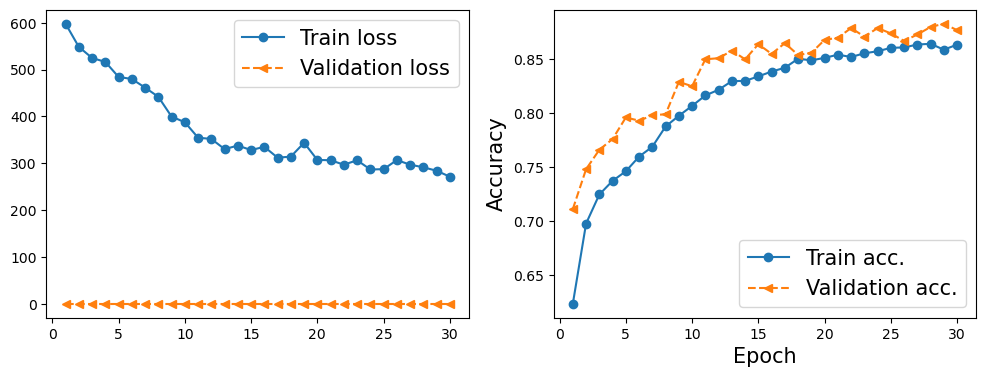

In [25]:
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr,hist[0],'-o',label='Train loss')
ax.plot(x_arr,hist[1],'--<',label='Validation loss')
ax.legend(fontsize=15)
ax = fig.add_subplot(1,2,2)
ax.plot(x_arr,hist[2],'-o',label='Train acc.')
ax.plot(x_arr,hist[3],'--<',label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch',size=15)
ax.set_ylabel('Accuracy',size=15)
plt.show()

In [26]:
accuracy_test = 0
model.eval()
with torch.no_grad():
    for x_batch,y_batch in test_dl:
        pred = model(x_batch)[:,0]
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum()
accuracy_test /= len(test_dl.dataset)
print(f'Test accuracy: {accuracy_test:.4f}')

Test accuracy: 0.8678


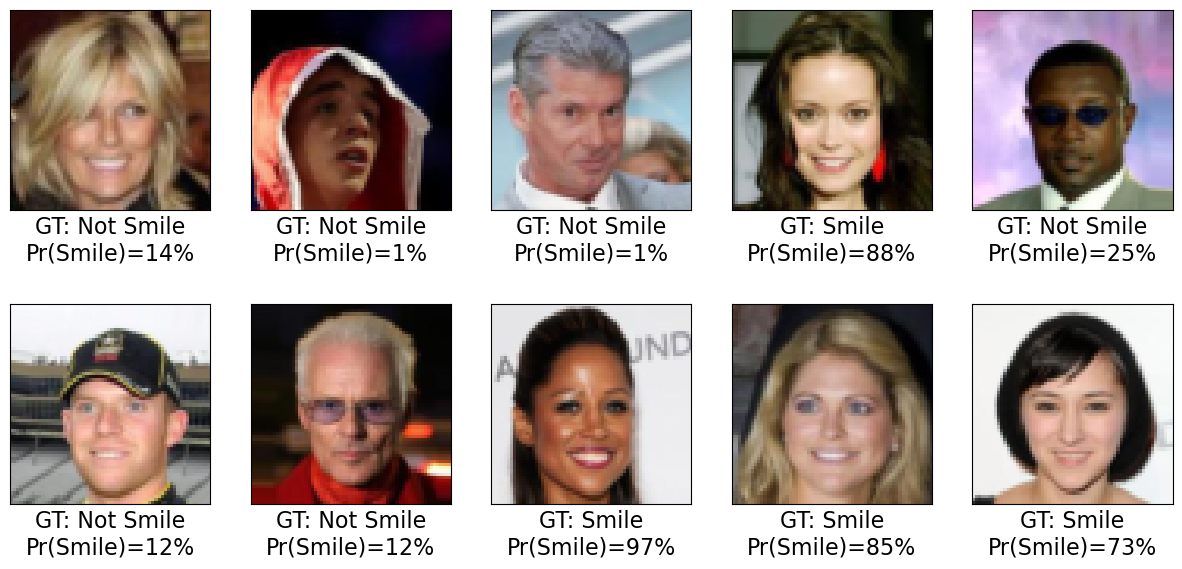

In [27]:
pred = model(x_batch)[:,0]*100
fig = plt.figure(figsize=(15,7))
for j in range(10,20):
    ax = fig.add_subplot(2,5,j-10+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(x_batch[j].permute(1,2,0))
    if y_batch[j] == 1:
        label='Smile'
    else:
        label='Not Smile'
    ax.text(
    0.5,-0.15,
    f'GT: {label:s}\nPr(Smile)={pred[j]:.0f}%',
    size=16,
    horizontalalignment='center',
    verticalalignment='center',
    transform=ax.transAxes
    )
plt.show()